<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/all_words_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.interpolate
import os
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Dropout, Input, Reshape, GRU
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.models import Model, load_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def covariance(matrix):
  # matrix = np.delete(matrix,(0,1,9,12,16,15,17,23,31,34,39,48,53,63), 0)
  matrix = np.delete(matrix,(0,9,31,63), 0)
  res_mat = (np.cov(matrix,bias=True))
  return res_mat

In [4]:
def loadMatricesLong(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      if f == "Read_me.txt":
        continue
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)

In [5]:
def loadMatricesShort(dir):
  matrices_c1 = []
  matrices_c2 = []
  matrices_c3 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
      matrices_c3.extend([covariance(matrix) for matrix in last_beep[2]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2),np.array(matrices_c3)),axis=0)

#SHORT CLASSES (OUT, IN, UP) LONG CLASSES (COOPERATE, INDEPENDENT)

In [6]:
def loadMatrices():
  short_mat=[]
  long_mat=[]
  
  short_mat = loadMatricesShort("drive/My Drive/dataset/Short_words/")
  long_mat = loadMatricesLong("drive/My Drive/dataset/Long_words/")
  return np.concatenate((short_mat,long_mat),axis=0)


In [24]:
data = loadMatrices()

In [25]:
data.shape

(2500, 60, 60)

In [26]:
import json
def splitTestSet(arr):
  arr = arr.tolist()
  # Small 0
  arr2 = arr[450:461]
  arr[450:461] = []
  # Small 1
  arr2 = np.concatenate((arr2,arr[900:911]),axis=0)
  arr[900:911] = []
  # Small 2
  arr2 = np.concatenate((arr2,arr[1420:1431]),axis=0)
  arr[1420:1431] = []
  # Long 0
  arr2 = np.concatenate((arr2,arr[1830:1841]),axis=0)
  arr[1830:1841] = []
  # Long 1
  arr2 = np.concatenate((arr2,arr[2350:2361]),axis=0)
  arr[2350:2361] = []

  test_list = arr2.tolist()
  with open('testData.json','w') as test_dump :
    json.dump(test_list,test_dump,indent = 4)
  return np.array(arr)

In [27]:
data = splitTestSet(data)
print(data.shape)

(2445, 60, 60)


(489, 60, 60)
(489, 60, 60)


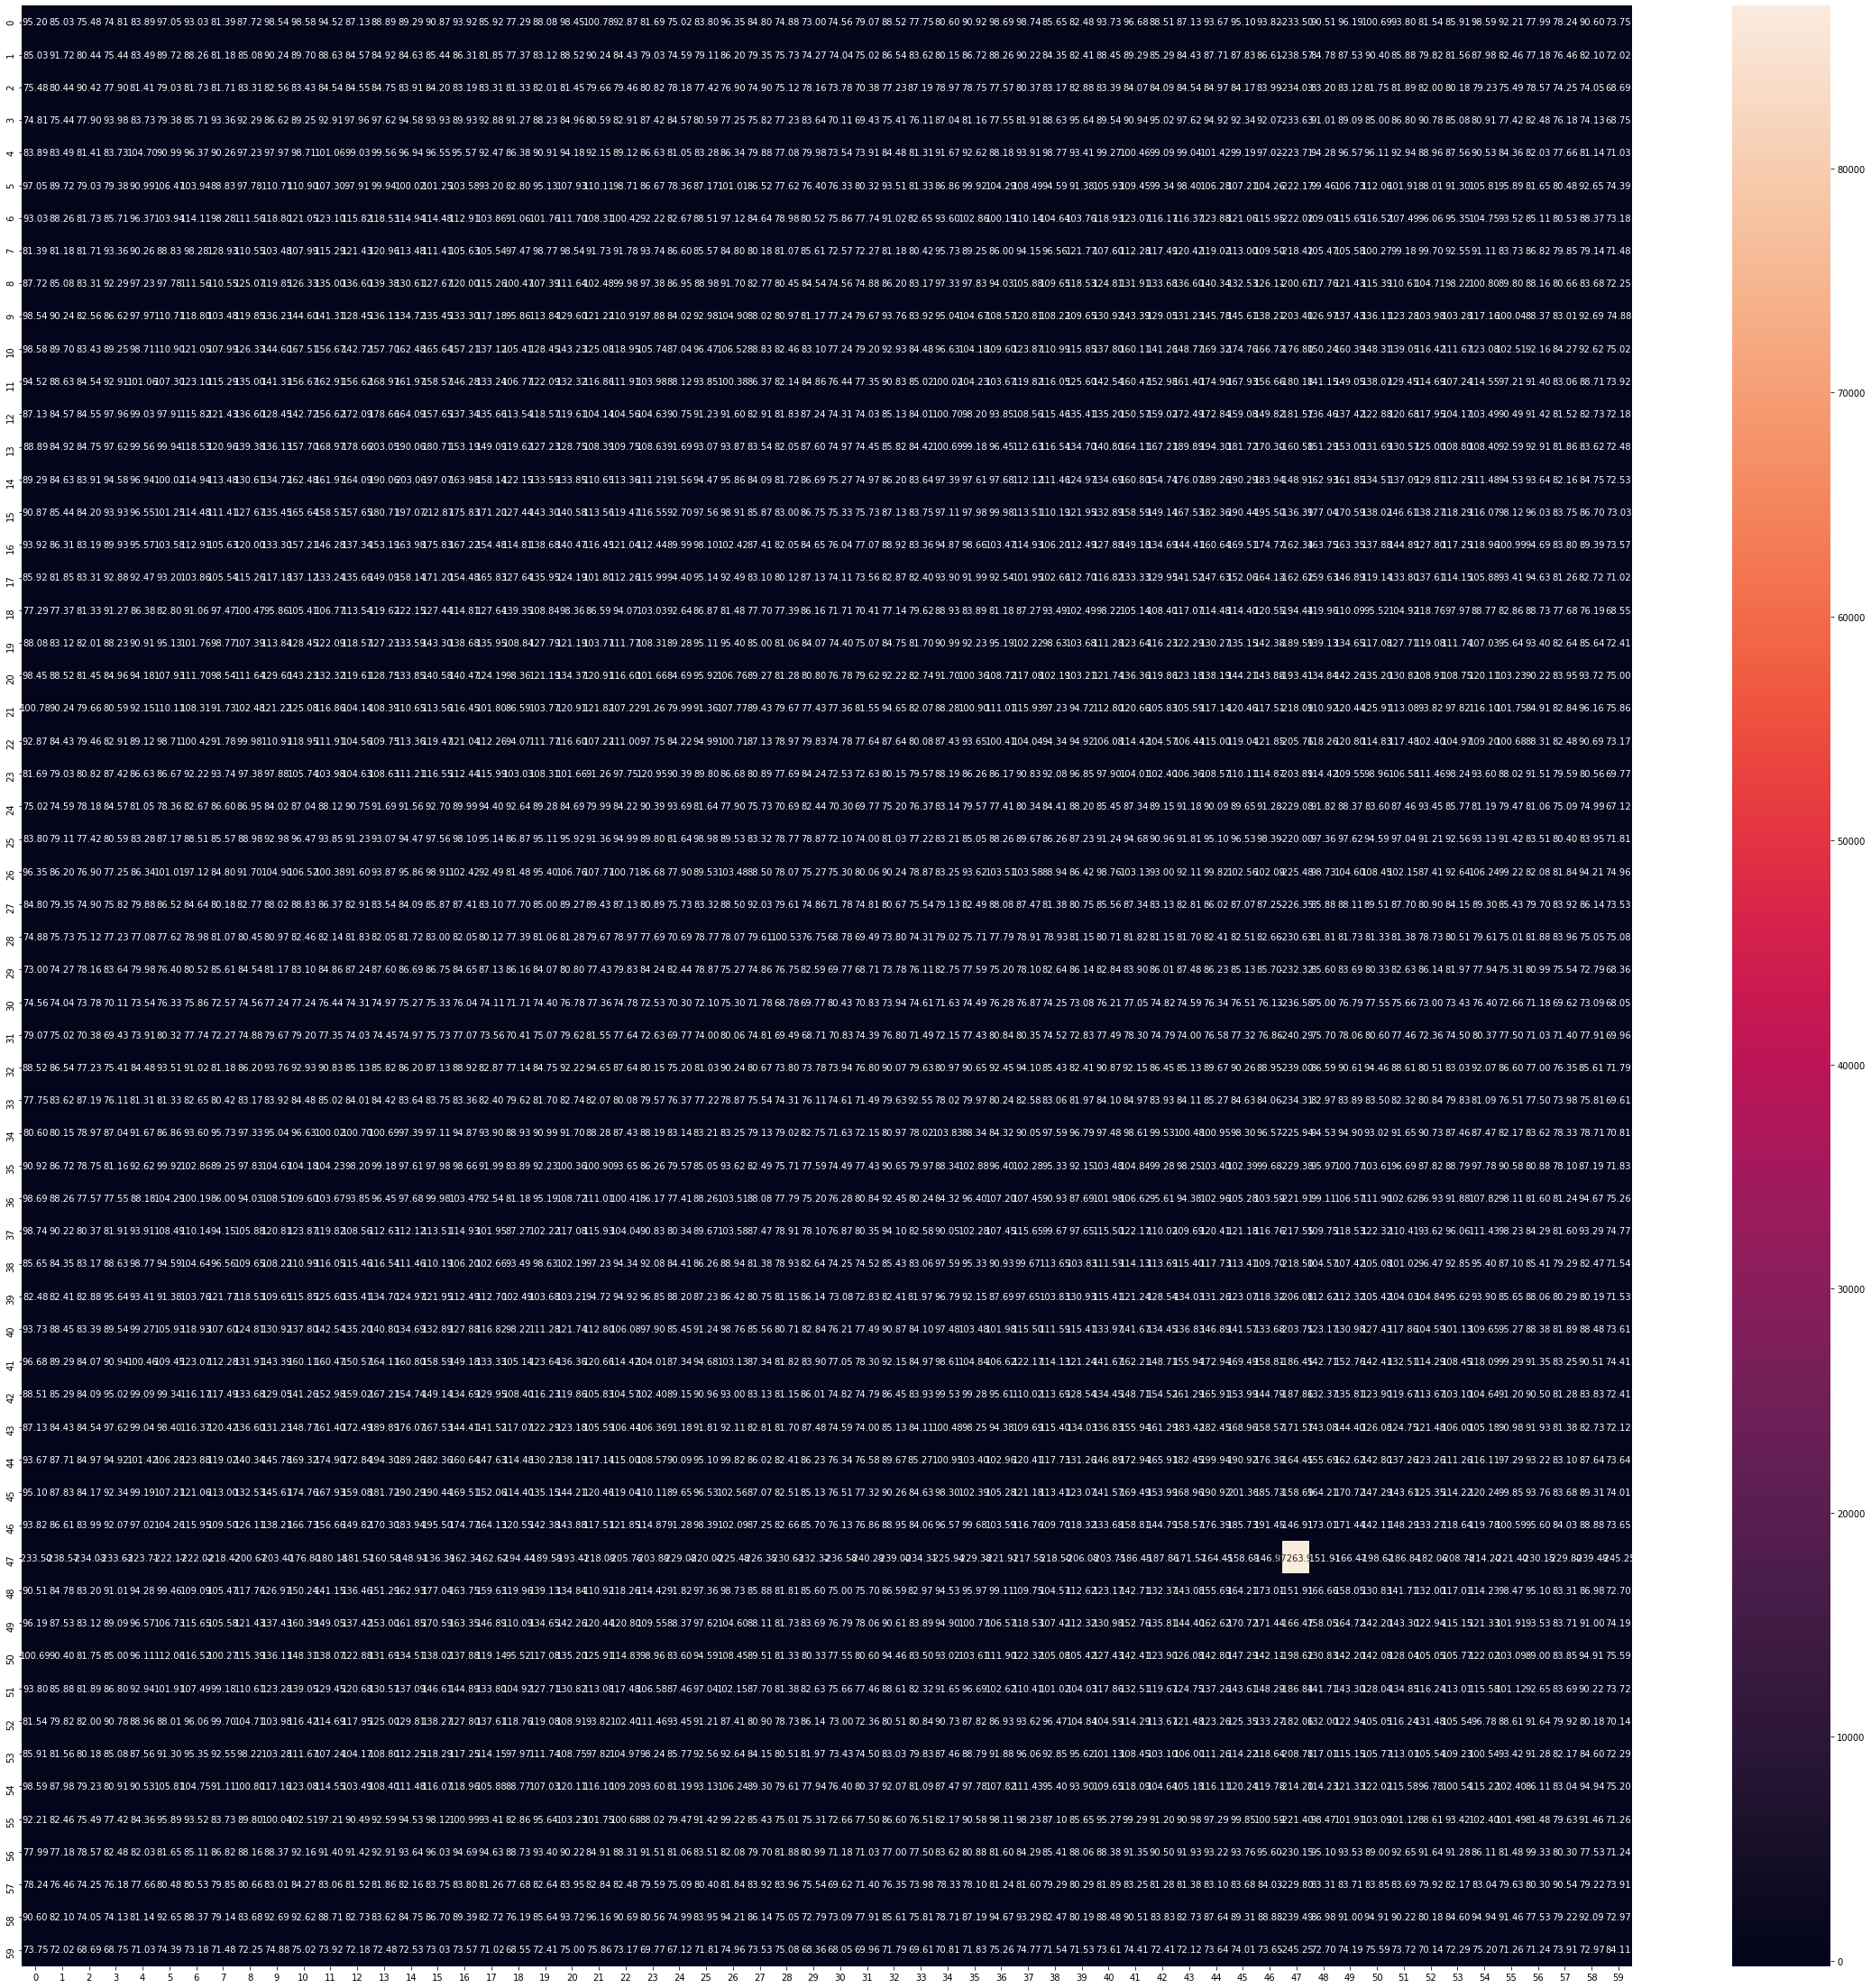

In [28]:
classes = np.array_split(data,5)
print(classes[0].shape)
print(classes[1].shape)
c1_cov_mean = np.mean(classes[0],axis=0)
plt.figure(figsize=(40, 40))
sns.heatmap(c1_cov_mean, annot=True, fmt='.2f')
plt.show()
# c2_cov_mean = np.mean(c1[1],axis=0)/

In [29]:
labels = np.concatenate((np.zeros(489),np.ones(489),np.full(489,2),np.full(489,3),np.full(489,4)),axis=0)
print(labels)

[0. 0. 0. ... 4. 4. 4.]


In [30]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=5)
print(labels.shape,labels)

(2445, 5) [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [37]:
visible = Input(shape=(60,60))
cov1 = Conv1D(filters=60, kernel_size=2, activation="relu")(visible)
# dropout1 = Dropout(0.25)(cov1)
cov2 = Conv1D(filters=60, kernel_size=4, activation="relu")(cov1)
# dropout2 = Dropout(0.5)(cov2)
newShape = Reshape((56,60), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(120, activation='relu')(f1)
d2 = Dense(120, activation='relu')(d1)
output = Dense(5, activation='softmax')(d2)
model = Model(inputs=visible, outputs=output)
model.summary()
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 60, 60)]          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 59, 60)            7260      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 56, 60)            14460     
_________________________________________________________________
newReshape (Reshape)         (None, 56, 60)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               403320    
_________________________________________________________________
dense_13 (Dense)             (None, 120)               1452

In [32]:
data, labels = shuffle(data, labels)
divide_percent = int(len(data)*0.2)
y_test = labels[0:divide_percent]
x_test = data[0:divide_percent]
train_data = data[divide_percent:len(data)]
train_labels = labels[divide_percent:len(labels)]

In [38]:
print(y_test.shape,x_test.shape,train_data.shape,train_labels.shape)

(489, 5) (489, 60, 60) (1956, 60, 60) (1956, 5)


In [39]:
train_data, train_labels = shuffle(train_data, train_labels)
model.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=64,epochs=200,verbose=1)

Epoch 1/200
31/31 [==============================] - 2s 32ms/step - loss: 42.7217 - accuracy: 0.1758 - val_loss: 275.1136 - val_accuracy: 0.1820
Epoch 2/200
31/31 [==============================] - 1s 25ms/step - loss: 10.7507 - accuracy: 0.2123 - val_loss: 177.9806 - val_accuracy: 0.2249
Epoch 3/200
31/31 [==============================] - 1s 26ms/step - loss: 5.1247 - accuracy: 0.2353 - val_loss: 133.0907 - val_accuracy: 0.2843
Epoch 4/200
31/31 [==============================] - 1s 26ms/step - loss: 3.3734 - accuracy: 0.2844 - val_loss: 60.8257 - val_accuracy: 0.3027
Epoch 5/200
31/31 [==============================] - 1s 26ms/step - loss: 3.0049 - accuracy: 0.2886 - val_loss: 178.6805 - val_accuracy: 0.2945
Epoch 6/200
31/31 [==============================] - 1s 26ms/step - loss: 2.6626 - accuracy: 0.3226 - val_loss: 111.4206 - val_accuracy: 0.3067
Epoch 7/200
31/31 [==============================] - 1s 25ms/step - loss: 2.4333 - accuracy: 0.3198 - val_loss: 47.9377 - val_accuracy:

In [40]:
predictions = model.predict(x_test)
np.round(predictions)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

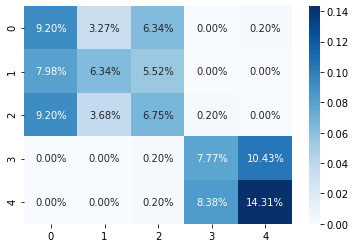

In [41]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [42]:
gru1 = GRU(60,activation="relu",return_sequences=True)(model.input)
# dropout3 = Dropout(0.25)(gru1)
gru2 = GRU(60,activation="relu")(gru1)
# dropout4 = Dropout(0.5)(gru2)
d3 = Dense(60, activation='relu')(gru2)
d4 = Dense(60, activation='relu')(d3)
output = Dense(5, activation='softmax')(d4)
model2 = Model(inputs=model.input, outputs=output)
model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 60, 60)]          0         
_________________________________________________________________
gru (GRU)                    (None, 60, 60)            21960     
_________________________________________________________________
gru_1 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dense_15 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_16 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 305       
Total params: 51,545
Trainable params: 51,545
Non-trainable params: 0
_______________________________________________________

In [43]:
optimizer = Adam(learning_rate=0.00001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
train_data, train_labels = shuffle(train_data, train_labels)
model2.fit(train_data,train_labels,validation_data=(x_test, y_test),batch_size=64,epochs=200, verbose=1)

Epoch 1/200
31/31 [==============================] - 6s 102ms/step - loss: 510.8731 - accuracy: 0.2134 - val_loss: 323.7892 - val_accuracy: 0.2147
Epoch 2/200
31/31 [==============================] - 3s 85ms/step - loss: 200.7131 - accuracy: 0.1889 - val_loss: 313.7798 - val_accuracy: 0.2229
Epoch 3/200
31/31 [==============================] - 3s 86ms/step - loss: 321.6047 - accuracy: 0.1899 - val_loss: 307.0598 - val_accuracy: 0.2270
Epoch 4/200
31/31 [==============================] - 3s 85ms/step - loss: 32.3177 - accuracy: 0.1948 - val_loss: 305.8167 - val_accuracy: 0.2147
Epoch 5/200
31/31 [==============================] - 3s 84ms/step - loss: 72.8804 - accuracy: 0.2005 - val_loss: 291.2052 - val_accuracy: 0.2168
Epoch 6/200
31/31 [==============================] - 3s 85ms/step - loss: 131.3015 - accuracy: 0.1795 - val_loss: 278.5216 - val_accuracy: 0.2106
Epoch 7/200
31/31 [==============================] - 3s 87ms/step - loss: 53.4274 - accuracy: 0.1904 - val_loss: 272.2271 - v

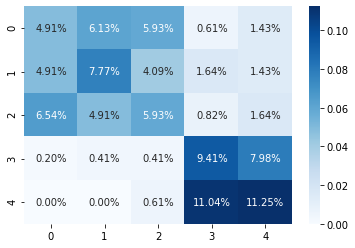

In [45]:
predictions = model2.predict(x_test)
np.round(predictions)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
for layer in model.layers:
  layer.trainable = False

for layer in model2.layers:
  layer.trainable = False

In [ ]:
def createFeatureModel(modelCNN, modelRNN):
  outputs = [modelCNN.layers[8].output,modelRNN.layers[6].output]
  merge = concatenate(outputs)
  featureModel = Model(inputs=modelCNN.input, outputs=merge)
  return featureModel

In [ ]:
def extractFeatures(model, data):
  features = model.predict(data,verbose=0)
  return features

In [ ]:
featureModel = createFeatureModel(model,model2)
train_features = extractFeatures(featureModel, train_data)
test_features = extractFeatures(featureModel, x_test)
print(train_features.shape, test_features.shape)

(2000, 180) (500, 180)


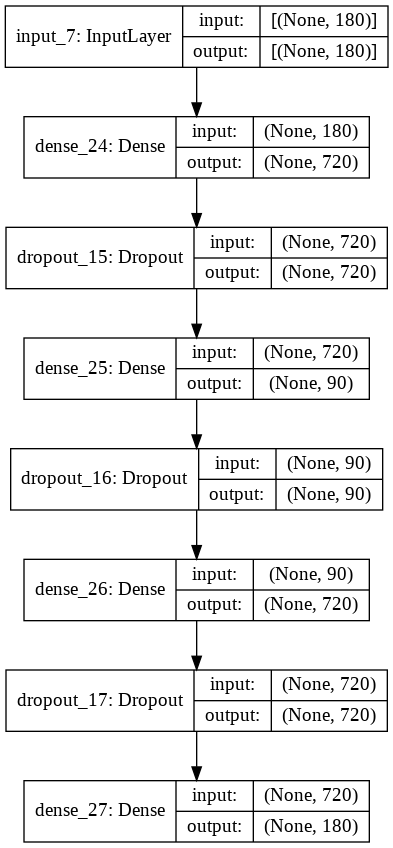

In [ ]:
daevisible = Input(shape=(180,))

encoder1 = Dense(720, activation='relu')(daevisible)
dropout5 = Dropout(0.25)(encoder1)
encoder2 = Dense(90, activation='sigmoid')(dropout5)
dropout6 = Dropout(0.25)(encoder2)
decoder1 = Dense(720, activation='relu')(dropout6)
dropout7 = Dropout(0.25)(decoder1)
decoder2 = Dense(180, activation='tanh')(dropout7)
model3 = Model(inputs=daevisible, outputs=decoder2)
plot_model(model3, show_shapes=True, to_file='model_graph.png')

In [ ]:
optimizer = Adam(learning_rate=0.00001)
model3.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
history = model3.fit(x=train_features, y=train_features,epochs=200,batch_size=64,validation_data=(test_features, test_features),verbose=1)

Epoch 1/200
32/32 [==============================] - 1s 22ms/step - loss: 8256980.9899 - accuracy: 0.0094 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 2/200
32/32 [==============================] - 0s 15ms/step - loss: 78295860.9266 - accuracy: 0.0213 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 3/200
32/32 [==============================] - 0s 12ms/step - loss: 17163235.3820 - accuracy: 0.0360 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 4/200
32/32 [==============================] - 0s 12ms/step - loss: 4601695.0654 - accuracy: 0.0643 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 5/200
32/32 [==============================] - 0s 12ms/step - loss: 69681224.8875 - accuracy: 0.0698 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 6/200
32/32 [==============================] - 0s 11ms/step - loss: 5736597.8401 - accuracy: 0.0985 - val_loss: 659213184.0000 - val_accuracy: 0.1040
Epoch 7/200
32/32 [======================

In [ ]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))    
    print('Mean for anomaly scores: ', np.mean(loss))
    return loss

In [ ]:
predictionsDAE = model3.predict(test_features,verbose=1)
scores = anomalyScores(test_features,predictionsDAE)

16/16 [==============================] - 0s 2ms/step
Mean for anomaly scores:  0.002000002


In [ ]:
encoder = Model(model3.input, model3.layers[3].output)
predictedFeatures = encoder.predict(train_features)
print(predictedFeatures.shape,train_features.shape)

(2000, 90) (2000, 180)


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60, 60)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 59, 60)       7260        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 59, 60)       0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 56, 60)       14460       dropout_11[0][0]                 
___________________________________________________________________________________________

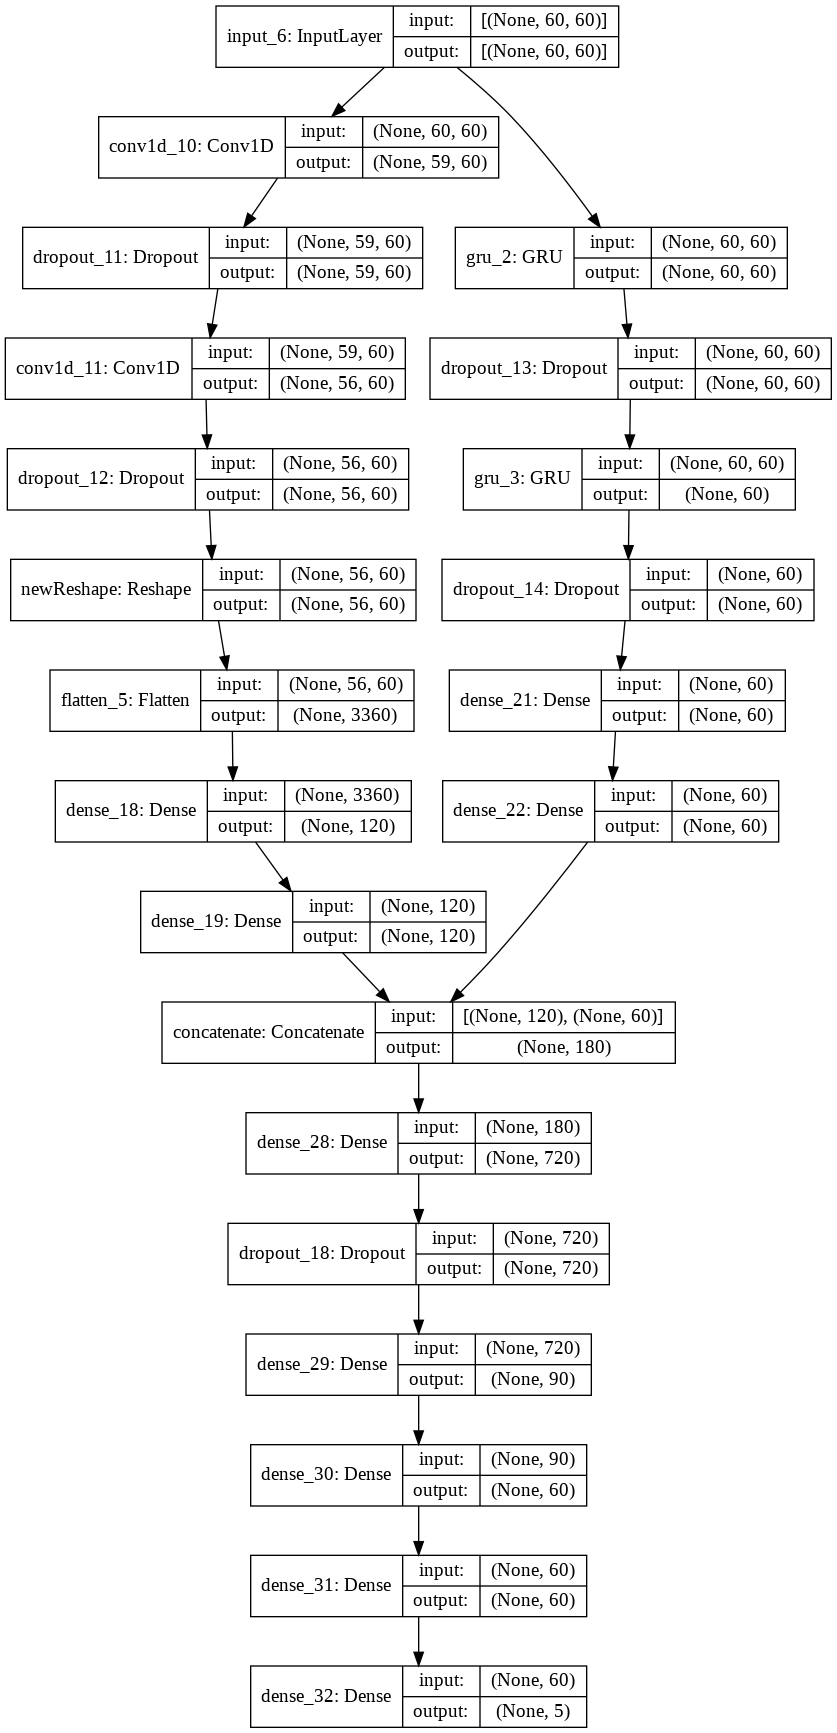

In [ ]:
featureOutput = featureModel.output
encoder1 = Dense(720, activation='relu')(featureOutput)
dropout5 = Dropout(0.25)(encoder1)
encoder2 = Dense(90, activation='sigmoid')(dropout5)
hidden1 = Dense(60, activation='relu')(encoder2)
hidden2 = Dense(60, activation='relu')(hidden1)
outputLayer = Dense(5, activation='softmax')(hidden2)
finalModel = Model(inputs=featureModel.input, outputs=outputLayer)
finalModel.summary()
plot_model(finalModel, show_shapes=True, to_file='model_graph.png')

In [ ]:
finalModel.layers[15].trainable = False
finalModel.layers[16].set_weights(model3.layers[1].get_weights())
finalModel.layers[16].trainable = False
finalModel.layers[17].set_weights(model3.layers[2].get_weights())
finalModel.layers[17].trainable = False
finalModel.layers[18].set_weights(model3.layers[3].get_weights())
finalModel.layers[18].trainable = False
finalModel.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60, 60)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 59, 60)       7260        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 59, 60)       0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 56, 60)       14460       dropout_11[0][0]                 
___________________________________________________________________________________________

In [ ]:
optimizer = Adam(learning_rate=0.00001)
finalModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_data, train_labels = shuffle(train_data, train_labels)
history = finalModel.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=64,epochs=200,verbose=1)

Epoch 1/200
32/32 [==============================] - 5s 81ms/step - loss: 1.9638 - accuracy: 0.2040 - val_loss: 1.9608 - val_accuracy: 0.1760
Epoch 2/200
32/32 [==============================] - 2s 69ms/step - loss: 1.9274 - accuracy: 0.2076 - val_loss: 1.9155 - val_accuracy: 0.1760
Epoch 3/200
32/32 [==============================] - 2s 64ms/step - loss: 1.8927 - accuracy: 0.1894 - val_loss: 1.8762 - val_accuracy: 0.1760
Epoch 4/200
32/32 [==============================] - 2s 64ms/step - loss: 1.8644 - accuracy: 0.1861 - val_loss: 1.8403 - val_accuracy: 0.1760
Epoch 5/200
32/32 [==============================] - 2s 60ms/step - loss: 1.8225 - accuracy: 0.1981 - val_loss: 1.8093 - val_accuracy: 0.1760
Epoch 6/200
32/32 [==============================] - 2s 64ms/step - loss: 1.7658 - accuracy: 0.2126 - val_loss: 1.7813 - val_accuracy: 0.1760
Epoch 7/200
32/32 [==============================] - 2s 64ms/step - loss: 1.7566 - accuracy: 0.1995 - val_loss: 1.7573 - val_accuracy: 0.1760
Epoch 

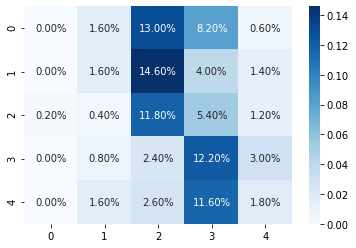

In [ ]:
predictions = finalModel.predict(x_test,verbose=0)
np.round(predictions)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
train_data, train_labels = shuffle(train_data, train_labels)

In [ ]:
visible = Input(shape=(60,60))
#CNN
cov1 = Conv1D(filters=60, kernel_size=2, activation="relu")(visible)
cov2 = Conv1D(filters=60, kernel_size=4, activation="relu")(cov1)
newShape = Reshape((56,60), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(120, activation='relu')(f1)
d2 = Dense(120, activation='relu')(d1)

#RNN
lstm1 = GRU(60,activation="relu",return_sequences=True)(visible)
lstm2 = GRU(60,activation="relu")(lstm1)
d3 = Dense(60, activation='relu')(lstm2)
d4 = Dense(60, activation='relu')(d3)
#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(720, activation='relu')(merge)
encoder2 = Dense(90, activation='relu')(encoder1)
decoder1 = Dense(720, activation='relu')(encoder2)
decoder2 = Dense(180, activation='relu')(decoder1)

#FNN
hidden1 = Dense(60, activation='relu')(encoder2)
hidden2 = Dense(60, activation='relu')(hidden1)
output = Dense(5, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 60)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 59, 60)       7260        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 56, 60)       14460       conv1d[0][0]                     
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 56, 60)       0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
optimizer = Adam(learning_rate=0.00001)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_data, train_labels = shuffle(train_data, train_labels)

In [ ]:
print(train_labels.shape,train_data.shape)

(1956, 5) (1956, 60, 60)


In [ ]:
train_data, train_labels = shuffle(train_data, train_labels)  
history = model.fit(train_data,train_labels,validation_data=(x_test,y_test),epochs=200,verbose=1)


Epoch 1/200
62/62 [==============================] - 9s 90ms/step - loss: 5.7276 - accuracy: 0.1904 - val_loss: 324.4698 - val_accuracy: 0.2331
Epoch 2/200
62/62 [==============================] - 5s 84ms/step - loss: 3.1861 - accuracy: 0.2239 - val_loss: 42.0578 - val_accuracy: 0.3047
Epoch 3/200
62/62 [==============================] - 5s 85ms/step - loss: 1.6867 - accuracy: 0.3071 - val_loss: 2.8593 - val_accuracy: 0.3538
Epoch 4/200
62/62 [==============================] - 5s 84ms/step - loss: 1.5330 - accuracy: 0.3258 - val_loss: 23.4957 - val_accuracy: 0.3742
Epoch 5/200
62/62 [==============================] - 7s 112ms/step - loss: 1.5073 - accuracy: 0.3563 - val_loss: 7.4633 - val_accuracy: 0.3742
Epoch 6/200
62/62 [==============================] - 9s 148ms/step - loss: 1.4735 - accuracy: 0.3671 - val_loss: 1.5638 - val_accuracy: 0.2802
Epoch 7/200
62/62 [==============================] - 6s 104ms/step - loss: 1.5402 - accuracy: 0.3258 - val_loss: 1.4519 - val_accuracy: 0.3681

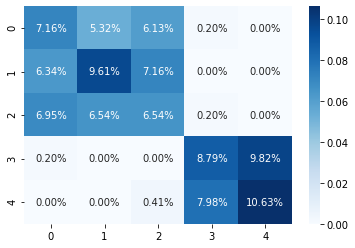

In [ ]:
predictions = model.predict(x_test,verbose=0)
np.round(predictions)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

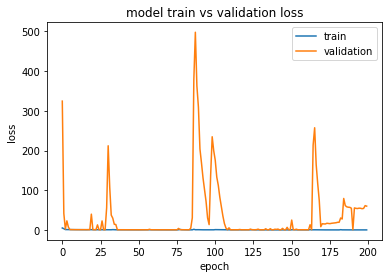

In [ ]:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

In [ ]:
model.save("imagined_speech.h5")

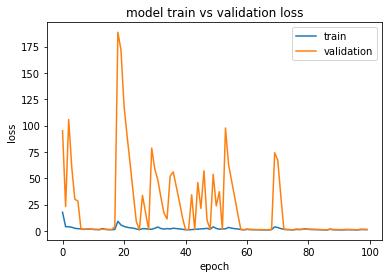

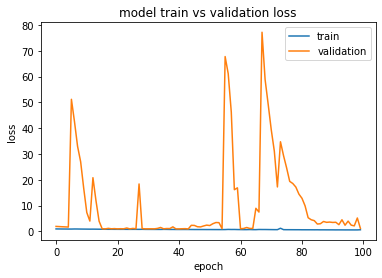

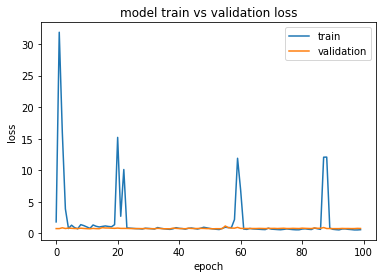

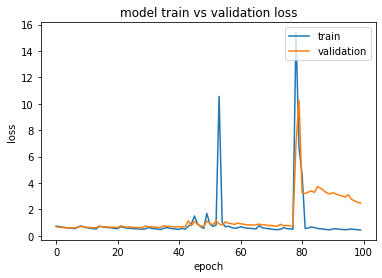

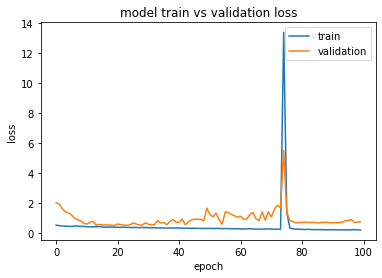

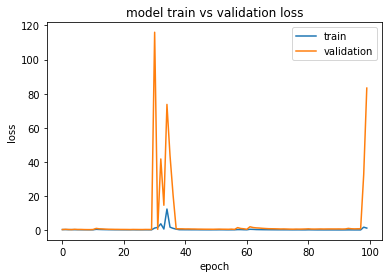

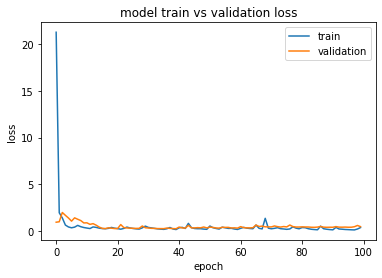

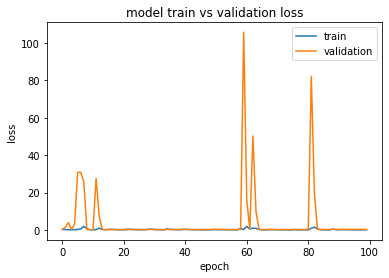

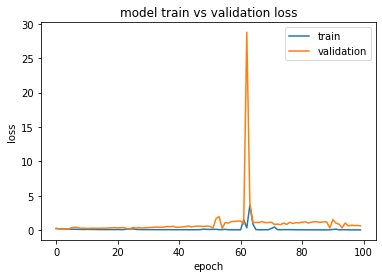

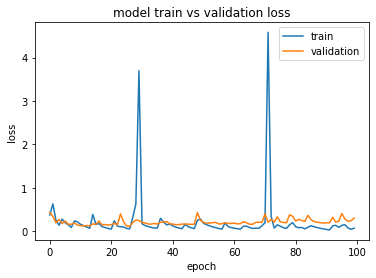

In [ ]:
for history in histories:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

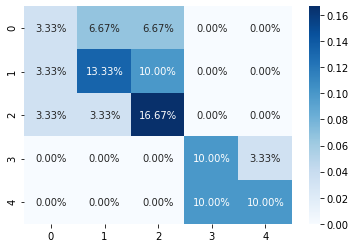

In [ ]:
  predictions_test = model.predict(x_test,verbose=0)
  np.round(predictions_test)
  rounded_labels_test = np.argmax(y_test, axis=1)
  rounded_predictions_test = np.argmax(predictions_test, axis=1)
  cf_test = confusion_matrix(rounded_labels_test,rounded_predictions_test)  # doctest: +SKIP
  sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt='.2%', cmap='Blues')
